# Comparing different datasets, sample level

- This notebook is focusing on comparing surface marker expression between NK cells and B cells, and NK cells and isotype controls (available for Neurips dataset).



Used NK cell markers are selected based on recent papers and documentation of Mustjoki group; 

- Pfefferle, A., et al. (2019). A Temporal Transcriptional Map of Human Natural Killer Cell Differentiation. BioRxiv, 630657. https://doi.org/10.1101/630657
- Melsen, J. E., et al. (2022). Single-cell transcriptomics in bone marrow delineates CD56dimGranzymeK+ subset as intermediate stage in NK cell differentiation. Frontiers in immunology, 13, 1044398. https://doi.org/10.3389/fimmu.2022.1044398
- Yang, C., et al.(2019). Heterogeneity of human bone marrow and blood natural killer cells defined by single-cell transcriptome. Nature communications, 10(1), 3931. https://doi.org/10.1038/s41467-019-11947-7




Datasets:

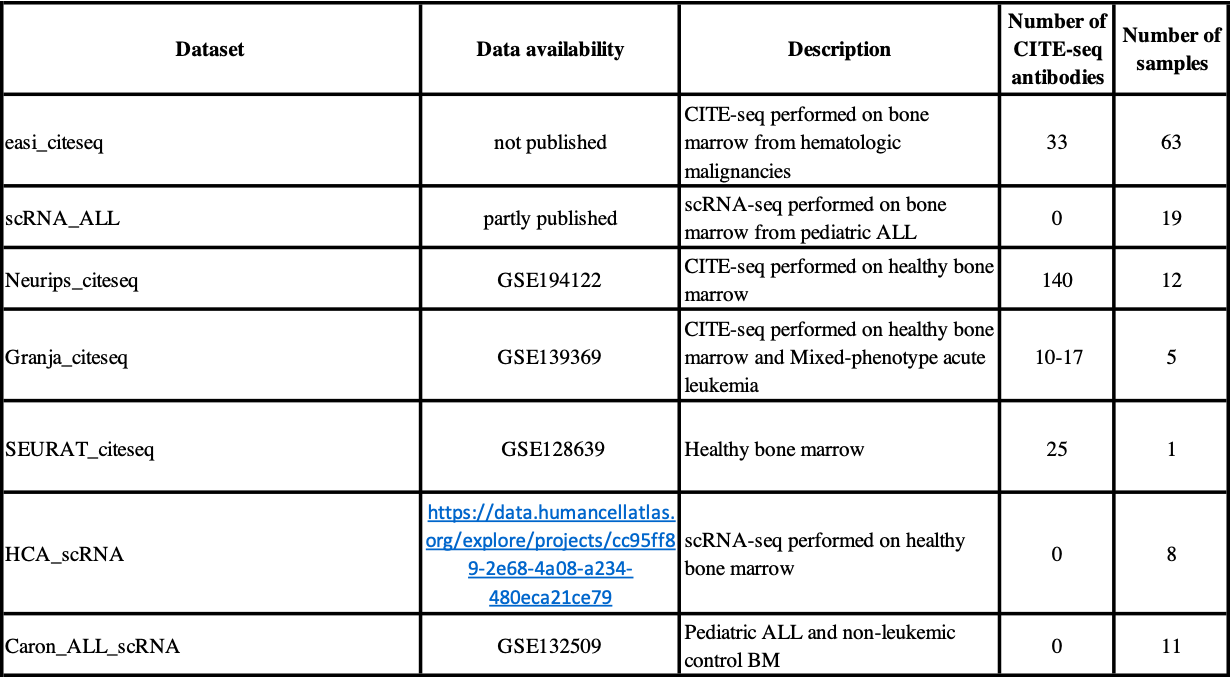

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## File preparations

### Neurips

In [2]:
#Neurips

adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [3]:
adata_neurips

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [4]:
#Select only NK cells

neurips_nk = adata_neurips[(adata_neurips.obs['cell_type'] == "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]

In [5]:
neurips_nk

View of AnnData object with n_obs × n_vars = 7388 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [6]:
neurips_nk.obs['cell_type'].unique().tolist()

['NK', 'NK CD158e1+']

In [7]:
#saving CLR normalized protein information

neurips_nk_prot=neurips_nk.obsm['protein_expression_clr_neurips']

In [8]:
neurips_nk_prot.shape

(7388, 139)

In [9]:
#To exclude columns that contain only zeros

neurips_nk_prot = pd.DataFrame(neurips_nk_prot)
neurips_nk_prot != 0
(neurips_nk_prot != 0).any(axis=0)
neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]
neurips_nk_prot = neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]


In [10]:
neurips_nk_prot.shape

(7388, 134)

### Granja

In [11]:
adata_granja = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_granja_norm.h5ad')

In [12]:
adata_granja.obs['cell_type'].unique().to_list()

['CD4+ T 1',
 'CD14+ monocyte 1',
 'Pre B',
 'Pro B',
 'CD8+ T',
 'Promonocyte',
 'CD14+ monocyte 2',
 'Plasmacytoid dendritic cell',
 'NK T 2',
 'Immature B',
 'Late erythoid precursor 1',
 'Pre B (cycling)',
 'NK',
 'Late erythoid precursor 3',
 'Early erythoid precursor',
 'CD16+ monocyte',
 'Conventional dendritic cell',
 'HSC',
 'NK T 1',
 'Late erythoid precursor 2',
 'Plasma B cell',
 'Stromal cell',
 'Megakaryocyte',
 nan]

In [13]:
#Select NK cells
granja_nk=adata_granja[adata_granja.obs['new_cell_type'] == 'NK' ]

In [14]:
granja_nk

View of AnnData object with n_obs × n_vars = 1033 × 8051
    obs: 'cell_type', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'eg_code', 'leiden_r1', 'new_cell_type', 'batch_group'
    uns: 'neighbors', 'new_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_granja'
    obsp: 'connectivities', 'distances'

In [15]:
granja_nk_prot=granja_nk.obsm['protein_expression_clr_granja']


In [16]:
granja_nk_prot.shape

(1033, 141)

In [17]:
#To exclude columns that contain only zeros

granja_nk_prot = pd.DataFrame(granja_nk_prot)
granja_nk_prot != 0
(granja_nk_prot != 0).any(axis=0)
granja_nk_prot.loc[:, (granja_nk_prot != 0).any(axis=0)]
granja_nk_prot = granja_nk_prot.loc[:, (granja_nk_prot != 0).any(axis=0)]


In [18]:
granja_nk_prot.shape

(1033, 14)

## Easigenomics

### Comments:

- Only NKT annotation available (NK + T cells)

In [19]:
adata_easi = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_easi_norm.h5ad')

In [20]:
adata_easi.obs['cell_type'].unique().to_list()

['NKT',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

In [21]:
#Select NK + T

easi_nkt=adata_easi[adata_easi.obs['cell_type'] == 'NKT' ]

In [22]:
easi_nkt

View of AnnData object with n_obs × n_vars = 27738 × 8051
    obs: 'cell_type', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'eg_code', 'leiden_r1', 'new_cell_type', 'batch_group'
    uns: 'neighbors', 'new_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr', 'protein_expression_dsb'
    obsp: 'connectivities', 'distances'

In [23]:
easi_nkt_prot=easi_nkt.obsm['protein_expression_clr']


In [24]:
#To exclude columns that contain only zeros

easi_nkt_prot = pd.DataFrame(easi_nkt_prot)
easi_nkt_prot != 0
(easi_nkt_prot != 0).any(axis=0)
easi_nkt_prot.loc[:, (easi_nkt_prot != 0).any(axis=0)]
easi_nkt_prot = easi_nkt_prot.loc[:, (easi_nkt_prot != 0).any(axis=0)]


### Seurat 

In [25]:
#Seurat

adata_seurat = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_seurat_norm.h5ad')

In [26]:
adata_seurat.obs['cell_type'].unique().to_list()

['Prog_RBC',
 'gdT',
 'CD4 Naive',
 'CD4 Memory',
 'CD14 Mono',
 'Naive B',
 'CD8 Naive',
 'Treg',
 'CD8 Effector_2',
 'NK',
 'GMP',
 'CD8 Effector_1',
 'CD16 Mono',
 'pDC',
 'CD8 Memory_1',
 'MAIT',
 'Memory B',
 'cDC2',
 'CD56 bright NK',
 'Prog_B 2',
 'Prog_Mk',
 'CD8 Memory_2',
 'Plasmablast',
 'HSC',
 'LMPP',
 'Prog_DC',
 'Prog_B 1']

In [27]:
#Select NK cells

seurat_nk=adata_seurat[adata_seurat.obs['new_cell_type'] == 'NK' ]

In [28]:
seurat_nk_prot=seurat_nk.obsm['protein_expression_clr_seurat']


In [29]:
seurat_nk_prot.shape

(1355, 141)

In [30]:
#To exclude columns that contain only zeros

seurat_nk_prot = pd.DataFrame(seurat_nk_prot)
seurat_nk_prot != 0
(seurat_nk_prot != 0).any(axis=0)
seurat_nk_prot.loc[:, (seurat_nk_prot != 0).any(axis=0)]
seurat_nk_prot = seurat_nk_prot.loc[:, (seurat_nk_prot != 0).any(axis=0)]


In [31]:
seurat_nk_prot.shape

(1355, 25)

## Comparisons

In [32]:
#NK cell markers (Reference 1)

nk_immature = ['CD56']
nk_activating= ['CD335', 'CD314', 'CD2', 'CD226']
nk_maturation= ['CD57']
nk_inhibitory= ['CD158e1']

nk_mustjoki = [nk_immature, nk_activating, nk_maturation, nk_inhibitory]
nk_mustjoki = list(np.concatenate(nk_mustjoki).flat)


In [33]:
#NK cell markers (Reference 2) used in Neurips antibody panel

nk_immature_pfef = ['CD56']
nk56dim = ['CD94','CD158b', 'CD57']

# nk_adaptive =['CD158b', 'CD159c, CD57'] CD159c not used in Neurips, so this is same as previous

nk_transition= ['TIGIT', 'CD155', 'CD226', 'CD161'] 

c1_pfef = ['CD195', 'CD122', 'CD94']
c2_pfef = ['CD62L', 'CD127', 'CD27', 'TIGIT']
c3_pfef = ['CD16', 'CD38']

pseudotime= ['CD161', 'CD94', 'CD56', 'CD5', 'CD7', 'CD122']


#bigger list including all markers

nk_pfef=[nk56dim, nk_transition, c1_pfef, c2_pfef, c3_pfef, pseudotime]
nk_pfef = list(np.concatenate(nk_pfef).flat)

In [34]:
# Reference 3, Melsen et al. 

cd56bright_mels_prot= ['CD56', "CD2"]
cd56dim_mels_1_prot = ['CD16']
cd56dim_mels_2_prot  = ['CD62L'] 
red_eff_mels_prot = ['CD16']
clust3_mels_prot = ['CD34']

nk_melsen = [cd56bright_mels_prot, cd56dim_mels_1_prot,cd56dim_mels_2_prot,red_eff_mels_prot, clust3_mels_prot]
nk_melsen = list(np.concatenate(nk_melsen).flat)

In [35]:
# Reference 4, Yang et al. 

is_nk_yang_prot = ['CD94','CD56'] 
inflamed_nk_prot = ['CD69']
active_nk_prot = ["CD69"]
maturation_prot = ['CD62L', 'CD57'] 
adaptive_high_prot = ['CD52']
mature_prot = ['CD57']
terminal_prot = ['CX3CR1']

nk_yang = [is_nk_yang_prot,inflamed_nk_prot,active_nk_prot,maturation_prot,adaptive_high_prot,mature_prot,terminal_prot]

nk_yang = list(np.concatenate(nk_yang).flat)

In [36]:
#markers from all references

nk_all = [nk_mustjoki, nk_pfef, nk_melsen, nk_yang]
nk_all = list(np.concatenate(nk_all).flat)

In [37]:
#remove duplicates
nk_all = list(set(nk_all))

In [38]:
#Full list of NK cell surface markers collected from 4 references
nk_all

['CD52',
 'CD127',
 'CD226',
 'CD335',
 'CD195',
 'CD56',
 'CD5',
 'CD69',
 'CD94',
 'CD16',
 'CD122',
 'CD57',
 'CD38',
 'CD158e1',
 'CD34',
 'TIGIT',
 'CD314',
 'CD7',
 'CD62L',
 'CD2',
 'CD27',
 'CX3CR1',
 'CD161',
 'CD155',
 'CD158b']

## Neurips

In [39]:
#check which markers were used in Neurips

listOfmarkers= nk_all

nk_neu = []

for x in listOfmarkers:
    if x in neurips_nk_prot.columns:
        nk_neu.append(x)



In [40]:
nk_neu

['CD52',
 'CD127',
 'CD226',
 'CD335',
 'CD195',
 'CD56',
 'CD5',
 'CD69',
 'CD94',
 'CD16',
 'CD122',
 'CD57',
 'CD38',
 'CD158e1',
 'TIGIT',
 'CD314',
 'CD7',
 'CD62L',
 'CD2',
 'CD27',
 'CX3CR1',
 'CD161',
 'CD155',
 'CD158b']

### Comparing to Naive B cells

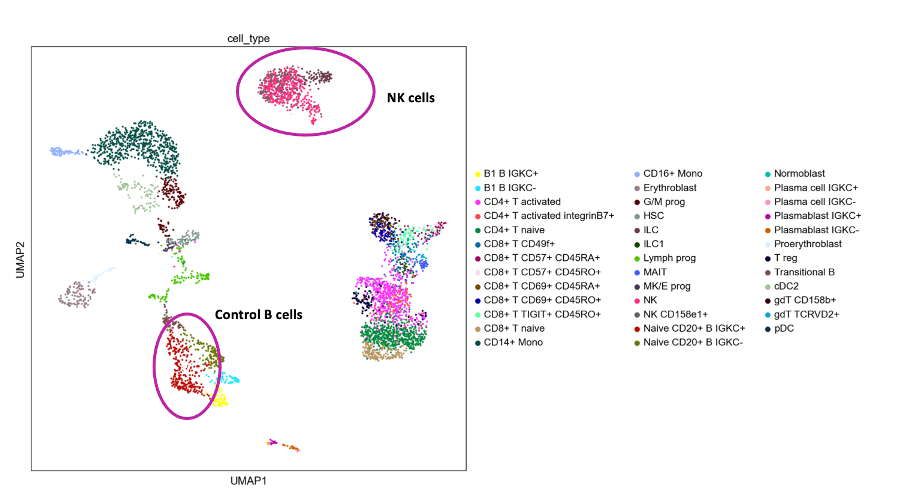

Naive B cells were selected for comparisons, since these cells are not expected to express same surface markers as NK cells at high levels. Additionally, size of the B and NK cells is comparable. UMAP generated from s4d1 sample.

In [41]:
#Sample names
samples=adata_neurips.obs['POOL'].unique().tolist()

In [42]:
#saving protein expression in NK cells into a list

list_prot_nk=[]

for sample in samples:
    eg=adata_neurips[(adata_neurips.obs['cell_type'] ==  "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_neurips']
    prot_marker=prot[nk_neu]
    list_prot_nk.append(prot_marker)
    

In [43]:
#Adding cell type information after sample name

string= " NK cells"

samples_nk = [x + string for x in samples]

In [44]:
#Adding sample names

list_neurips=[]

for i in range(len(list_prot_nk)):
    sample= list_prot_nk[i]
    sample["Sample"]=samples_nk[i]
    list_neurips.append(sample)
    
#creating df

df_nk=pd.concat(list_neurips, axis=0)

In [45]:
#selecting B cells

neurips_b=adata_neurips[adata_neurips.obs['cell_type'] == 'Naive CD20+ B IGKC+']

In [46]:
#saving protein counts in B cells into a list

list_prot_b=[]

for sample in samples:
    eg=adata_neurips[adata_neurips.obs['cell_type'] == 'Naive CD20+ B IGKC+']
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_neurips']
    prot_marker=prot[nk_neu]
    list_prot_b.append(prot_marker)

In [47]:
#Adding cell type information to sample names

string= " B cells"

samples_b = [x + string for x in samples]

In [48]:
#Adding sample names

list_neurips_b=[]

for i in range(len(list_prot_b)):
    sample= list_prot_b[i]
    sample["Sample"]=samples_b[i]
    list_neurips_b.append(sample)
    
#creating df
    
df_b=pd.concat(list_neurips_b, axis=0)

In [49]:
#NK cells

df_nk.shape

(7388, 25)

In [50]:
#B cells

df_b.shape

(3835, 25)

In [51]:
df=pd.concat([df_nk, df_b], axis=0)

df.shape

(11223, 25)

In [52]:
#Assigning sample pairs (one sample, B + NK cells)

data1 = df[(df['Sample'] == "s4d1 NK cells") | (df['Sample'] == 's4d1 B cells')].assign(Samplepair= 1)   
data2 = df[(df['Sample'] == "s3d6 NK cells") | (df['Sample'] == 's3d6 B cells')].assign(Samplepair= 2)   
data3 = df[(df['Sample'] == "s1d2 NK cells") | (df['Sample'] == 's1d2 B cells')].assign(Samplepair= 3)   
data4 = df[(df['Sample'] == "s2d1 NK cells") | (df['Sample'] == 's2d1 B cells')].assign(Samplepair= 4)   
data5 = df[(df['Sample'] == "s3d7 NK cells") | (df['Sample'] == 's3d7 B cells')].assign(Samplepair= 5)   
data6 = df[(df['Sample'] == "s2d4 NK cells") | (df['Sample'] == 's2d4 B cells')].assign(Samplepair=6)   
data7 = df[(df['Sample'] == "s1d1 NK cells") | (df['Sample'] == 's1d1 B cells')].assign(Samplepair=7)   
data8 = df[(df['Sample'] == "s4d9 NK cells") | (df['Sample'] == 's4d9 B cells')].assign(Samplepair=8)   
data9 = df[(df['Sample'] == "s4d8 NK cells") | (df['Sample'] == 's4d8 B cells')].assign(Samplepair=9)   
data10 = df[(df['Sample'] == "s2d5 NK cells") | (df['Sample'] == 's2d5 B cells')].assign(Samplepair=10)
data11 = df[(df['Sample'] == "s3d1 NK cells") | (df['Sample'] == 's3d1 B cells')].assign(Samplepair=11)   
data12 = df[(df['Sample'] == "s1d3 NK cells") | (df['Sample'] == 's1d3 B cells')].assign(Samplepair=12) 

In [53]:
#df from assigned sample pairs

cdf = pd.concat([data1, data2, data3 ,data4, data5, data6, data7, data8, data9, data10, data11, data12])


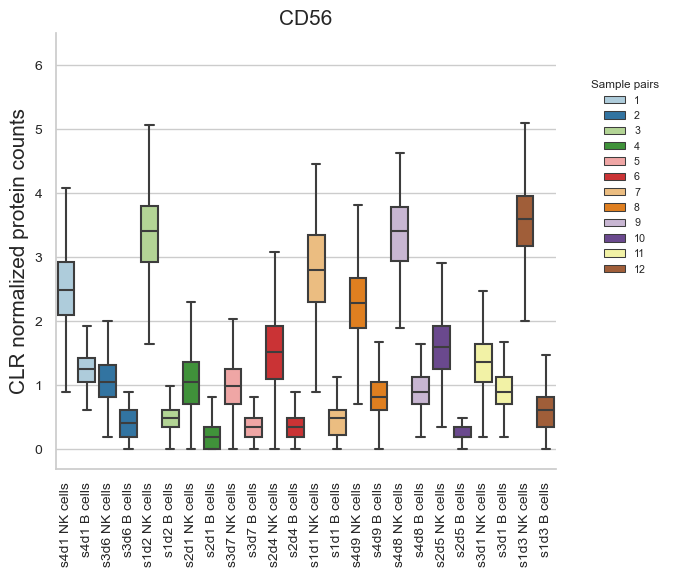

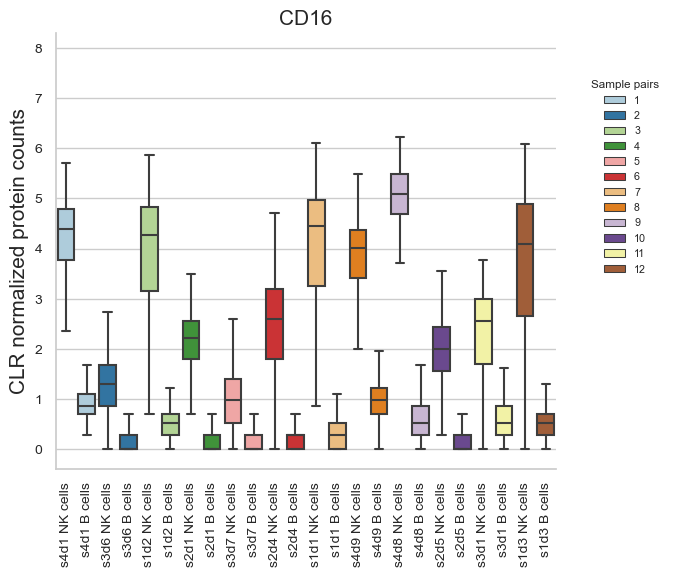

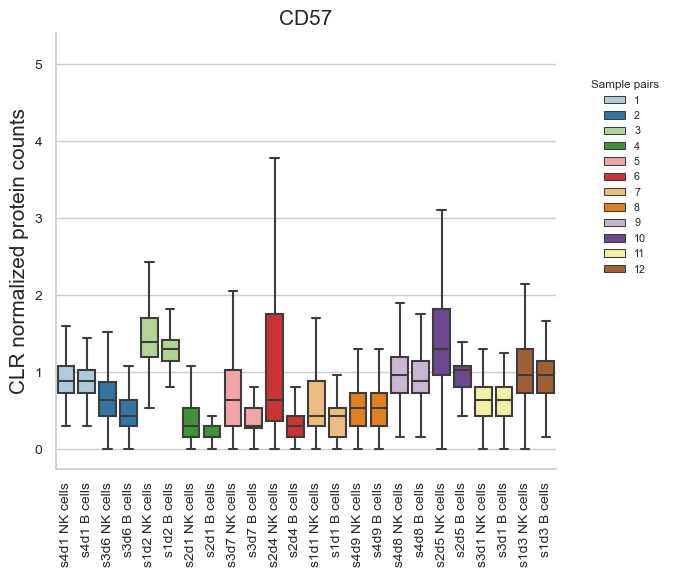

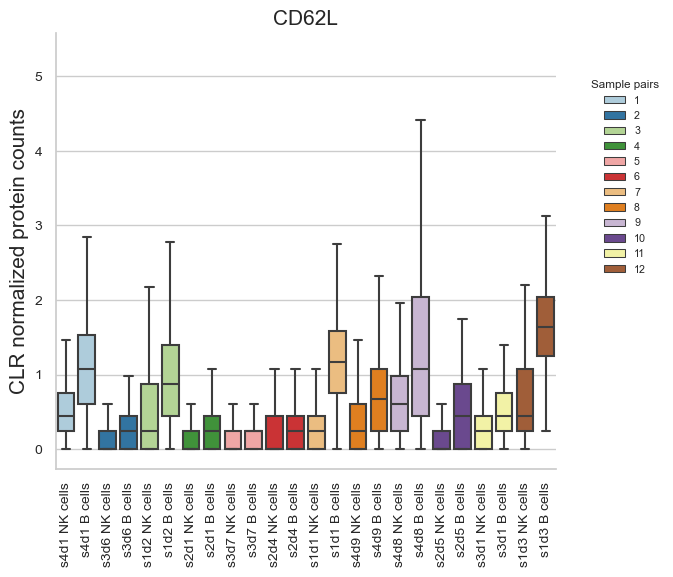

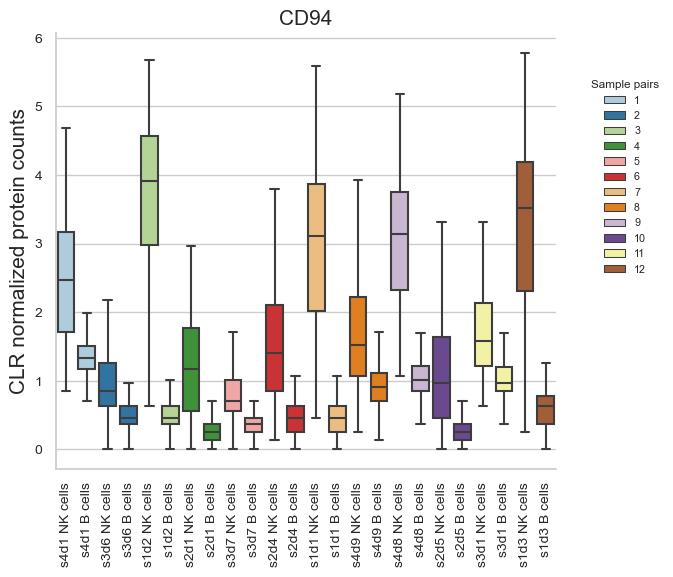

In [54]:
#CD56
sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD56", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD56")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel=None)
ax.set_ylabels('CLR normalized protein counts', fontsize= 15)
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD56", fontsize=15)

plt.show()


#CD16

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD16", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel=None)
ax.set_ylabels('CLR normalized protein counts', fontsize= 15)
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD16", fontsize=15)

plt.show()

#CD57

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD57", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel=None)
ax.set_ylabels('CLR normalized protein counts', fontsize= 15)
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD57", fontsize=15)

plt.show()

#CD62L

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD62L", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel=None)
ax.set_ylabels('CLR normalized protein counts', fontsize= 15)
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD62L", fontsize=15)

plt.show()

#CD94

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD94", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD94")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel=None)
ax.set_ylabels('CLR normalized protein counts', fontsize= 15)
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD94", fontsize=15)

plt.show()

- CLR normalized surface protein counts in NK and B cells from each sample is plotted. - Generally signals of NK markers are higher in NK cells compared to B cells as expected, but signal strength varies between samples. 
- In some cases signal from B cells in one sample is as high as signal from NK cells in other sample. Also between markers there seems to be differences. CD56 and CD94 are showing good separation between NK and B cells, but for CD57 results are not clear, which indicates that CD56 staining might not be so good? 

### Comparing to isotype controls 

- CLR normalized isotype control information was available for Neurips data
- Isotype controls are primary antibodies lacking specificity to the target cell types. The purpose of these controls is to reveal unspecific antibody staining and be negative controls to separate non-specific background signal from specific antibody signal.  
- Here 5 different isotype controls: 'Mouse-IgG1, Mouse-IgG2a, Mouse-IgG2b, Rat-IgG2b, Rat-IgG1, Rat-IgG2a. 

In [121]:
samples=adata_neurips.obs['POOL'].unique().tolist()

In [122]:
#saving isotype control df, only NK cells. 

ig_ab = neurips_nk.obsm['ADT_isotype_controls']

In [123]:
#collecting column names

isotype_col = ig_ab.columns

In [124]:
isotype_col

Index(['Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'Rat-IgG1',
       'Rat-IgG2a'],
      dtype='object')

In [125]:
#saving isotype marker counts from all samples into a list

list_isotype=[]

for sample in samples:
    eg=adata_neurips[(adata_neurips.obs['cell_type'] ==  "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['ADT_isotype_controls']
    prot_marker=prot[isotype_col]
    list_isotype.append(prot_marker)

In [126]:
#Adding sample names

thelist=[]

for i in range(len(list_isotype)):
    sample= list_isotype[i]
    sample["Sample"]=samples[i]
    thelist.append(sample)

#Creating df

df_isotype=pd.concat(thelist, axis=0)

In [127]:
#dropping "sample" column
df_nk = df_nk.drop(df_nk.columns[-1], axis=1)

In [128]:
#Combine df of NK cell marker counts + isotype controls

df=pd.concat([df_nk, df_isotype], axis = 1)
df.shape

(7388, 29)

In [148]:
df

,CD52,CD127,CD226,CD335,CD195,CD56,CD5,CD69,CD94,CD16,...,CD27,CX3CR1,CD161,Mouse-IgG1,Mouse-IgG2a,Mouse-IgG2b,Rat-IgG2b,Rat-IgG1,Rat-IgG2a,Sample
GTAGTACCAATCCTTT-1-s4d1,0.694828,0.692022,1.855921,2.672570,1.044572,1.601517,1.239691,1.443633,2.475005,4.836061,...,1.113825,2.338199,2.562388,0.371773,0.415173,0.371773,0.062345,0.176461,0.228980,s4d1
CTGTGGGTCATGCGGC-1-s4d1,1.013739,0.914940,2.063015,1.546571,0.977560,1.922291,0.115761,0.869988,1.408073,3.951286,...,0.293414,2.035570,1.798177,0.533398,0.162271,0.424311,0.301850,0.000000,0.424311,s4d1
GCAACATTCGCAAGAG-1-s4d1,1.072649,0.558651,0.836601,1.007587,0.828345,1.756883,0.478490,1.047030,2.174035,3.118694,...,0.293414,1.265139,0.985646,0.677794,0.592188,0.448242,0.077696,0.217030,0.077696,s4d1
TCACGGGTCGCACGAC-1-s4d1,0.812797,1.177096,2.508450,2.201969,1.044572,1.952325,0.478490,1.047030,3.016060,4.501690,...,0.293414,1.962265,2.830602,0.521819,0.186917,0.480314,0.186917,0.242190,0.480314,s4d1
CGCCAGAAGACCATTC-1-s4d1,0.849218,0.692022,2.302183,1.449409,1.275098,2.719623,0.551793,1.328073,2.826218,4.197592,...,0.519981,1.577418,2.217873,0.763261,0.386335,0.431098,0.386335,0.339475,0.126401,s4d1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCATTCGTCCAATCA-1-s1d3,0.288523,0.558651,2.268910,3.804646,0.313669,3.864781,0.620087,0.654712,4.481286,5.349072,...,0.519981,1.663052,2.495432,0.087238,0.310881,0.087238,0.167473,0.241745,0.087238,s1d3
ACATTTCCAGCAGTGA-1-s1d3,0.652195,0.222694,1.776121,2.293776,0.652893,3.148632,0.684015,0.000000,2.122566,3.356777,...,0.293414,1.420428,2.070415,0.280537,0.000000,0.000000,0.000000,0.150074,0.000000,s1d3
TGAGACTTCCTTCAGC-1-s1d3,0.406586,0.222694,1.689396,1.283286,0.439966,3.530574,0.313483,0.000000,0.365443,3.499154,...,0.293414,0.759167,0.488475,0.169536,0.000000,0.314454,0.314454,0.745992,0.441004,s1d3
GAGATGGTCCGCCTAT-1-s1d3,0.406586,0.692022,0.597636,2.225723,1.044572,4.224340,0.219500,1.328073,2.986818,5.436623,...,0.293414,1.324435,3.061729,0.282313,0.341988,0.078394,0.151086,0.000000,0.151086,s1d3


<Figure size 1000x500 with 0 Axes>

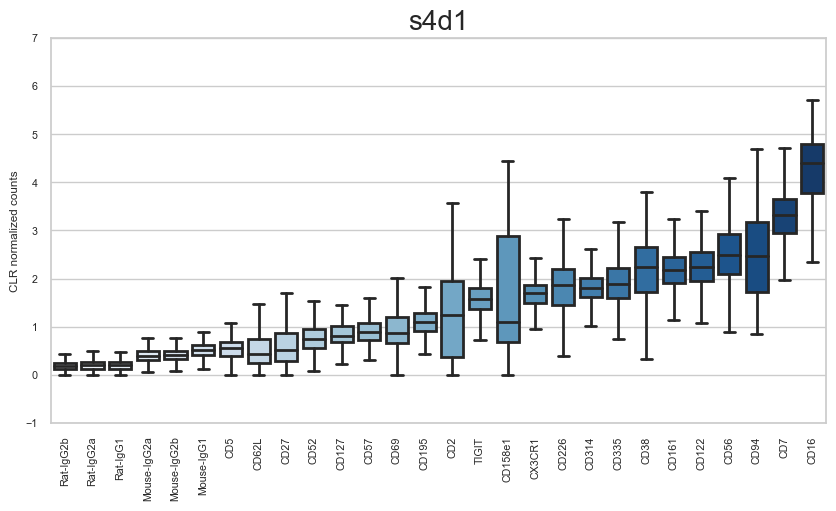

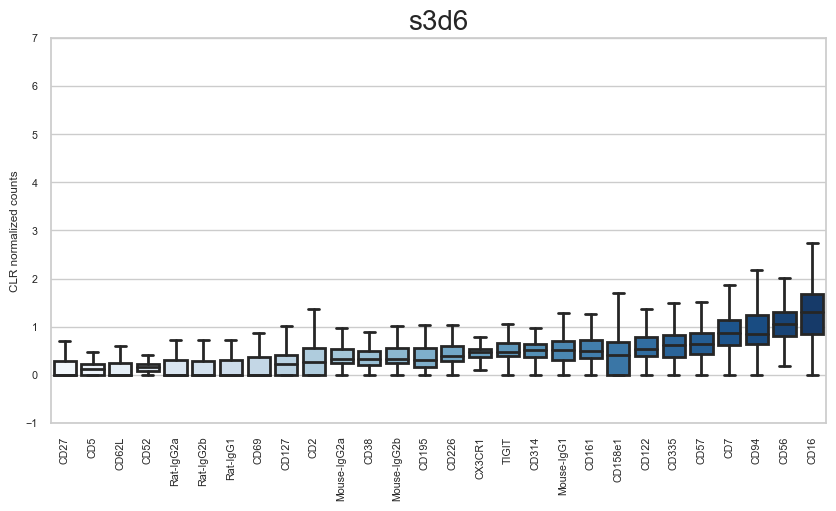

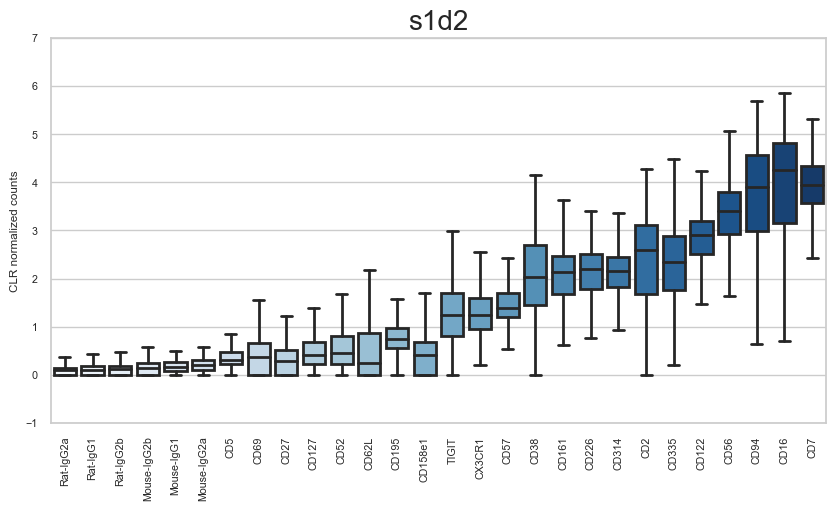

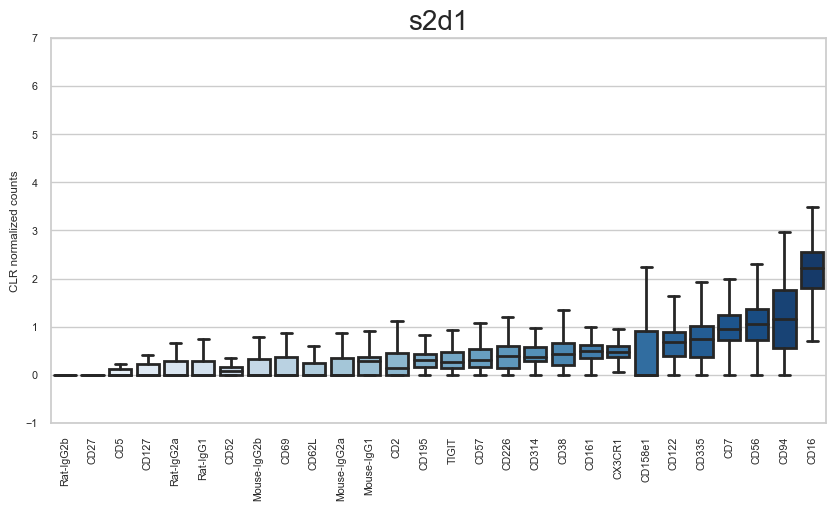

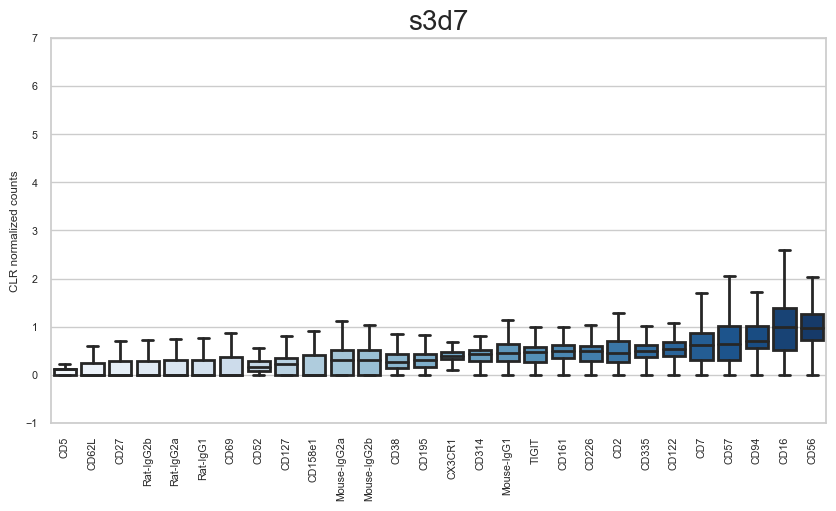

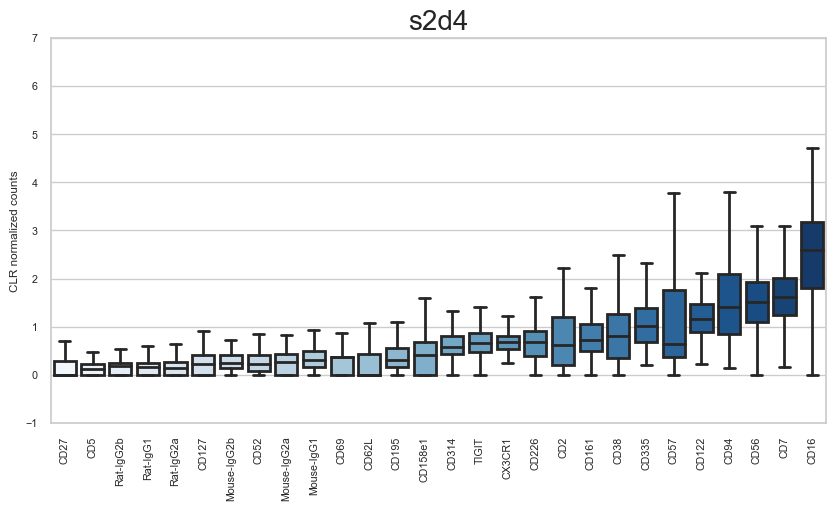

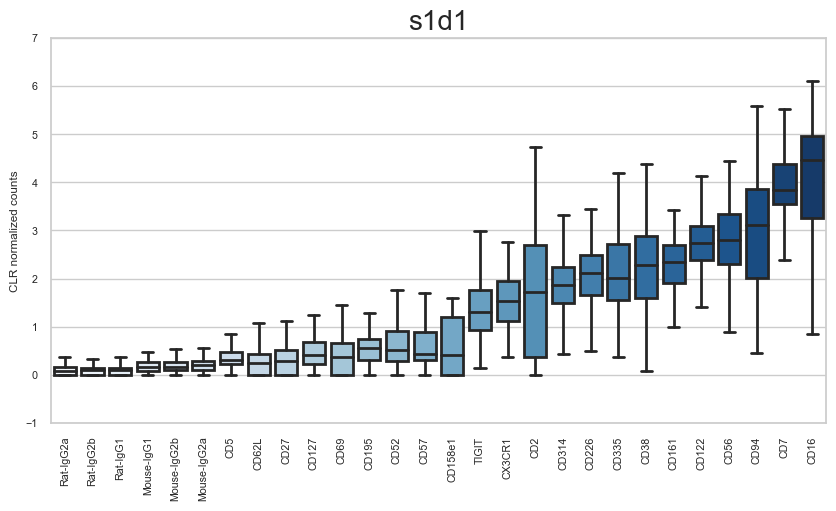

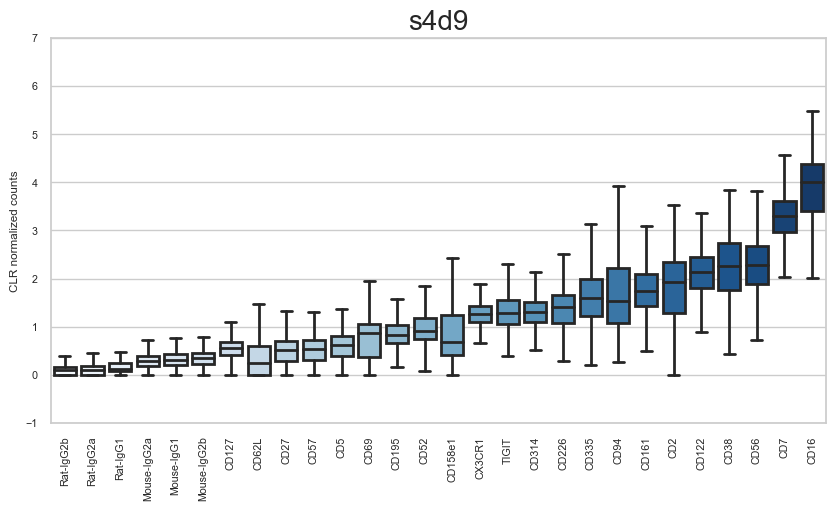

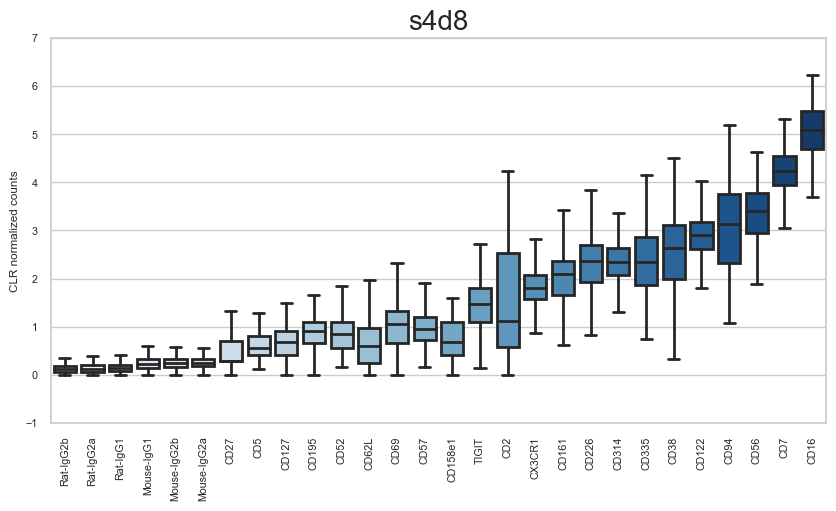

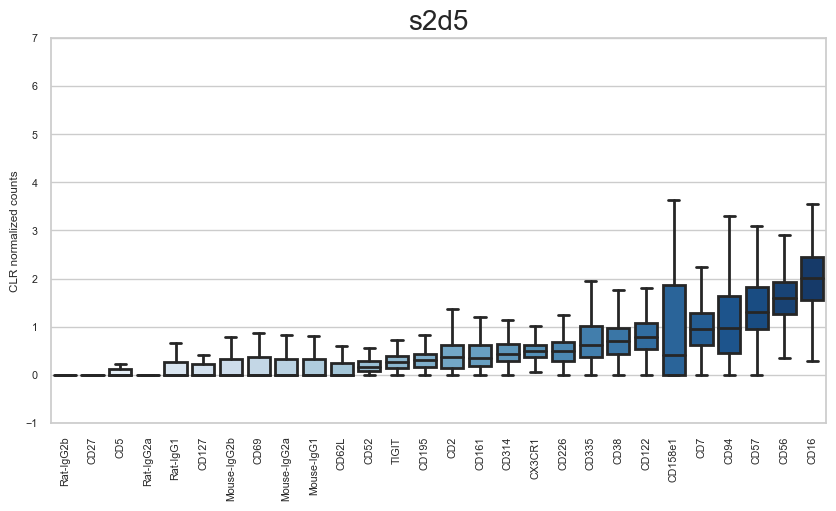

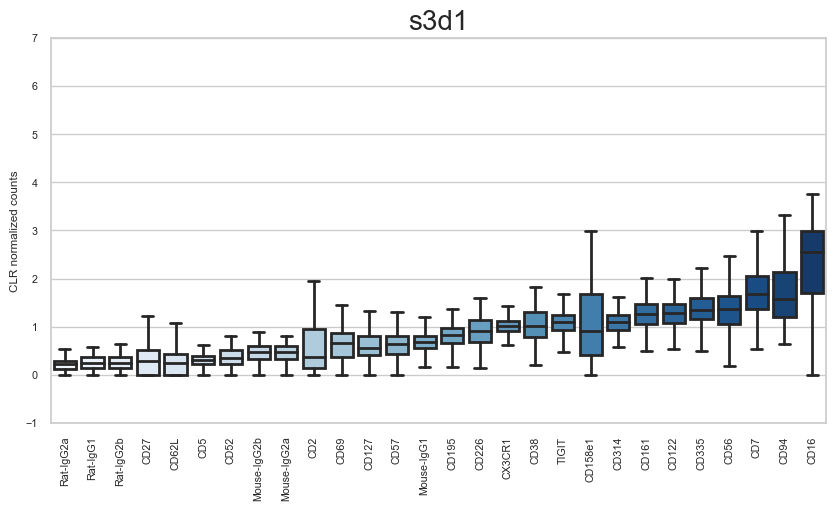

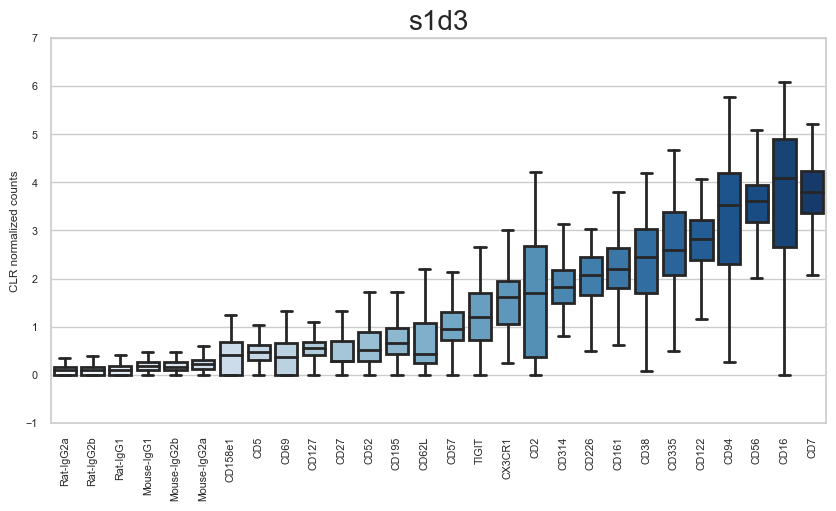

In [130]:
plt.figure(figsize=[10,5])

for sample in samples:
    eg=df[df['Sample'] ==  sample]
    index_sort = eg.mean().sort_values().index
    eg_sorted = eg[index_sort]
    plt.figure(figsize=[10,5])
    b=sns.boxplot(data=eg_sorted, fliersize=0, palette="Blues", linewidth=2) 
    b.set_xticklabels(b.get_xticklabels(),rotation=90) 
    b.set(ylabel= "CLR normalized counts")
    plt.title(sample, fontsize=20)
    plt.ylim(-1, 7)
    plt.show()

- Original anndata-file is subset so that only NK cells (based on cell_type annotations) are selected. 
- In these figures all CLR normalized marker counts are plotted for each sample and compared to isotype controls (Mouse-IgG1, Mouse-IgG2a, Mouse-IgG2b, Rat-IgG2b, Rat-IgG1,Rat-IgG2a). 
- Selected markers are well known NK cell markers. The most important NK cell markers CD56 and CD16 are showing clearly higher signal when comparing to isotype controls in all samples. CD7 and CD94 are also showing high signals across samples. However, some markers, such as CD57, are showing very low signals, which must be considered in next analysing steps.  

In [102]:
some_markers = ['CD56', 'CD57', 'CD62L', 'CD7', 'CD16', 'CD94']
plot_markers = [some_markers, isotype_col]


list(np.concatenate(plot_markers).flat)


['CD56',
 'CD57',
 'CD62L',
 'CD7',
 'CD16',
 'CD94',
 'Mouse-IgG1',
 'Mouse-IgG2a',
 'Mouse-IgG2b',
 'Rat-IgG2b',
 'Rat-IgG1',
 'Rat-IgG2a']

In [152]:
df_new = df[['CD56',
 'CD57',
 'CD62L',
 'CD7',
 'CD16',
 'CD94',
 'Mouse-IgG1',
 'Mouse-IgG2a',
 'Mouse-IgG2b',
 'Rat-IgG2b',
 'Rat-IgG1',
 'Rat-IgG2a',
 'Sample'
             ]]

In [153]:
df_new

,CD56,CD57,CD62L,CD7,CD16,CD94,Mouse-IgG1,Mouse-IgG2a,Mouse-IgG2b,Rat-IgG2b,Rat-IgG1,Rat-IgG2a,Sample
GTAGTACCAATCCTTT-1-s4d1,1.601517,0.957552,0.442160,3.421649,4.836061,2.475005,0.371773,0.415173,0.371773,0.062345,0.176461,0.228980,s4d1
CTGTGGGTCATGCGGC-1-s4d1,1.922291,1.085880,0.606553,3.476991,3.951286,1.408073,0.533398,0.162271,0.424311,0.301850,0.000000,0.424311,s4d1
GCAACATTCGCAAGAG-1-s4d1,1.756883,0.305082,0.606553,3.357011,3.118694,2.174035,0.677794,0.592188,0.448242,0.077696,0.217030,0.077696,s4d1
TCACGGGTCGCACGAC-1-s4d1,1.952325,0.637550,0.442160,3.455220,4.501690,3.016060,0.521819,0.186917,0.480314,0.186917,0.242190,0.480314,s4d1
CGCCAGAAGACCATTC-1-s4d1,2.719623,0.727649,0.245322,3.711122,4.197592,2.826218,0.763261,0.386335,0.431098,0.386335,0.339475,0.126401,s4d1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCATTCGTCCAATCA-1-s1d3,3.864781,0.637550,0.245322,4.146331,5.349072,4.481286,0.087238,0.310881,0.087238,0.167473,0.241745,0.087238,s1d3
ACATTTCCAGCAGTGA-1-s1d3,3.148632,0.727649,0.981402,3.178010,3.356777,2.122566,0.280537,0.000000,0.000000,0.000000,0.150074,0.000000,s1d3
TGAGACTTCCTTCAGC-1-s1d3,3.530574,3.093195,0.245322,2.179349,3.499154,0.365443,0.169536,0.000000,0.314454,0.314454,0.745992,0.441004,s1d3
GAGATGGTCCGCCTAT-1-s1d3,4.224340,2.702213,0.245322,4.419616,5.436623,2.986818,0.282313,0.341988,0.078394,0.151086,0.000000,0.151086,s1d3


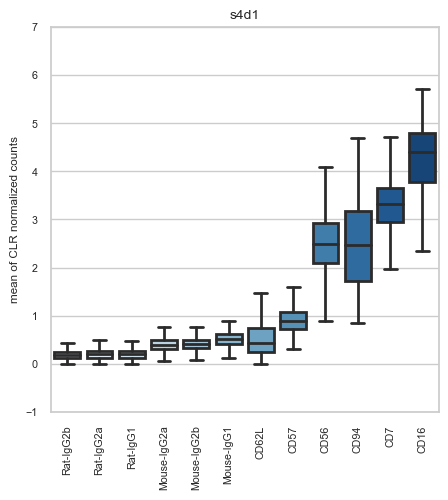

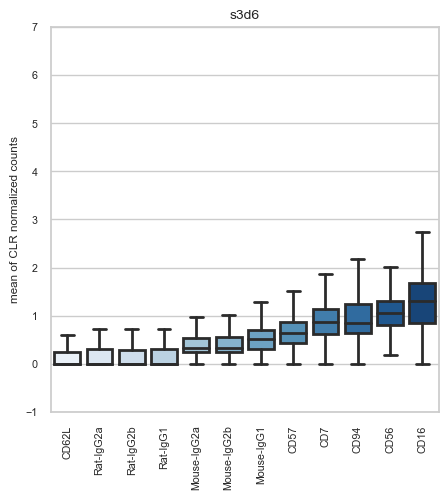

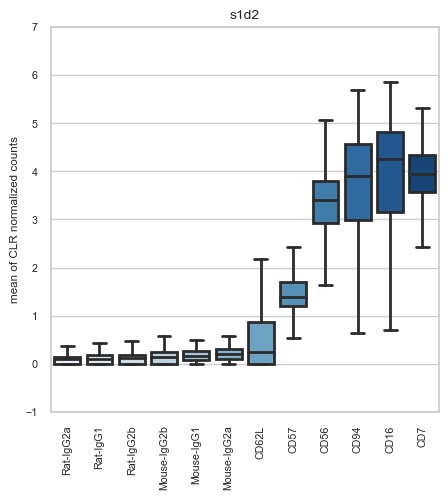

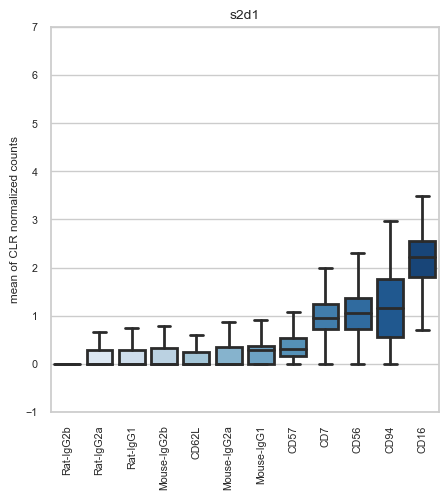

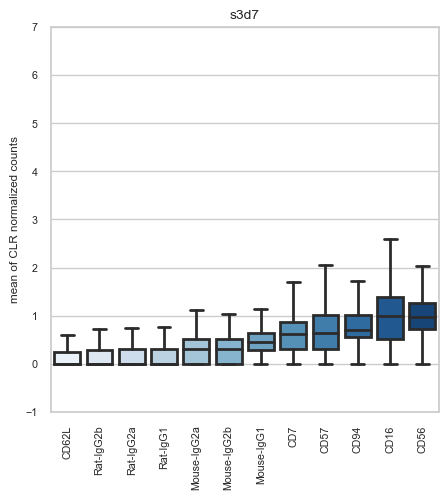

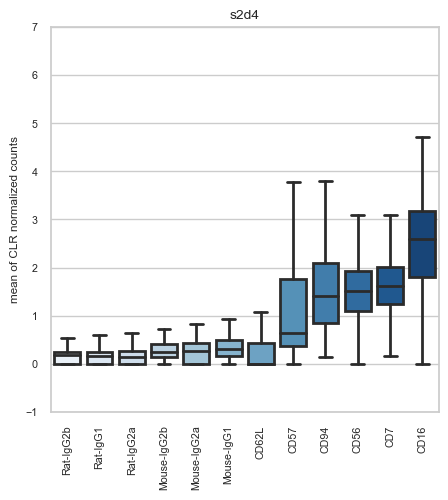

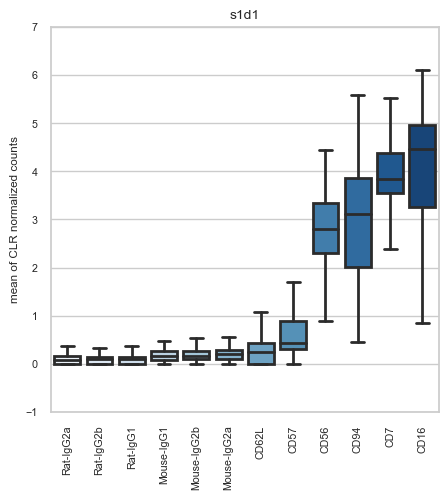

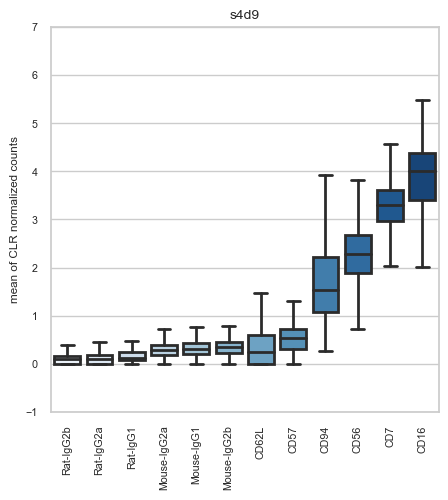

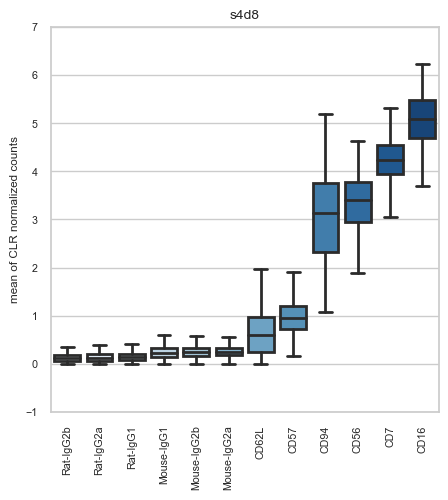

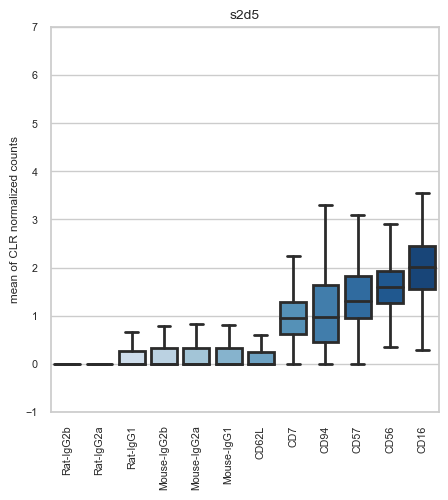

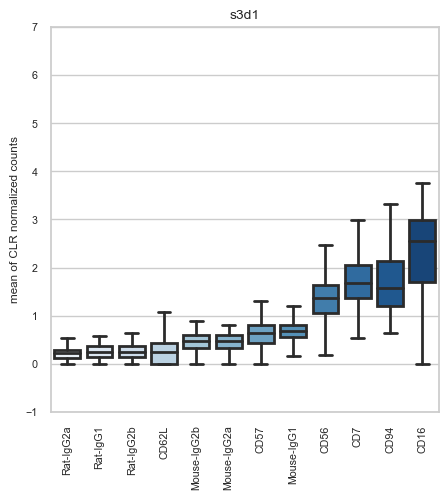

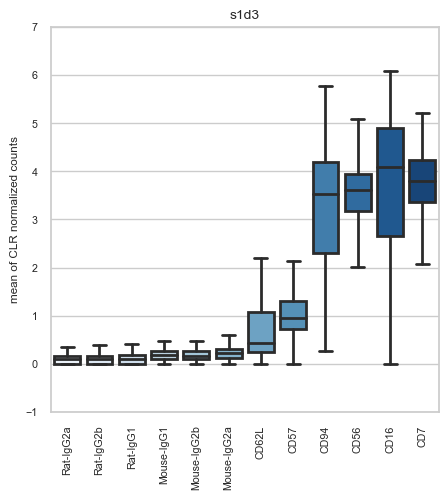

In [159]:
for sample in samples:
    eg=df_new[df_new['Sample'] ==  sample]
    index_sort = eg.mean().sort_values().index
    eg_sorted = eg[index_sort]
    plt.figure(figsize=[5,5])
    b=sns.boxplot(data=eg_sorted, fliersize=0, palette="Blues", linewidth=2) 
    b.set_xticklabels(b.get_xticklabels(),rotation=90) 
    b.set(ylabel= "mean of CLR normalized counts")
    plt.title(sample, fontsize=10)
    plt.ylim(-1, 7)
    plt.show()

### Granja

In [64]:
#Samples

samples_g=adata_granja.obs['POOL'].unique().tolist()
samples_g

['GSM4138872', 'GSM4138873', 'GSM4138874', 'GSM4138880', 'GSM4138885']

In [65]:
#checking which markers are used in Granja

listOfmarkers= nk_all

nk_granja= []

for x in listOfmarkers:
    if x in granja_nk_prot.columns:
        nk_granja.append(x)



In [66]:
nk_granja

['CD127', 'CD56', 'CD16', 'TIGIT']

In [67]:
#saving NK markers from all samples into a list

list_samples=[]

for sample in samples_g:
    eg = adata_granja[(adata_granja.obs['cell_type'] ==  "NK") | (adata_granja.obs['cell_type'] == "NK T 2") | (adata_granja.obs['cell_type'] == "NK T 1")]
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_granja']
    prot_marker=prot[nk_granja]
    list_samples.append(prot_marker)


In [68]:
string= " NK cells"

samples_g_nk = [x + string for x in samples_g]

In [69]:
list_granja=[]

for i in range(len(list_samples)):
    sample= list_samples[i]
    sample["Sample"]=samples_g_nk[i]
    list_granja.append(sample)

In [70]:
df_all_g=pd.concat(list_granja, axis=0)


In [71]:
df_all_g.shape

(1033, 5)

In [72]:
samples_g

['GSM4138872', 'GSM4138873', 'GSM4138874', 'GSM4138880', 'GSM4138885']

In [73]:
adata_granja.obs["cell_type"].unique().tolist()

['CD4+ T 1',
 'CD14+ monocyte 1',
 'Pre B',
 'Pro B',
 'CD8+ T',
 'Promonocyte',
 'CD14+ monocyte 2',
 'Plasmacytoid dendritic cell',
 'NK T 2',
 'Immature B',
 'Late erythoid precursor 1',
 'Pre B (cycling)',
 'NK',
 'Late erythoid precursor 3',
 'Early erythoid precursor',
 'CD16+ monocyte',
 'Conventional dendritic cell',
 'HSC',
 'NK T 1',
 'Late erythoid precursor 2',
 'Plasma B cell',
 'Stromal cell',
 'Megakaryocyte',
 nan]

In [74]:
#saving NK markers from all samples into a list, B cells

list_samples_b=[]

for sample in samples_g:
    eg=adata_granja[adata_granja.obs['new_cell_type'] == 'B']
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_granja']
    prot_marker=prot[nk_granja]
    list_samples_b.append(prot_marker)




In [75]:
#Adding cell type information after sample name
string= " B cells"

samples_g_b = [x + string for x in samples_g]


In [76]:
list_granja_b=[]

for i in range(len(list_samples_b)):
    sample= list_samples_b[i]
    sample["Sample"]=samples_g_b[i]
    list_granja_b.append(sample)

# creating df

df_all_g_b=pd.concat(list_granja_b, axis=0)

In [77]:
#Combining NK and B cell df

df=pd.concat([df_all_g, df_all_g_b], axis=0)

In [78]:
#Assigning sample pairs (one sample, NK + B cells)
data1 = df[(df['Sample'] == "GSM4138872 NK cells") | (df['Sample'] == 'GSM4138872 B cells')].assign(Samplepair= 1)   
data2 = df[(df['Sample'] == "GSM4138873 NK cells") | (df['Sample'] == 'GSM4138873 B cells')].assign(Samplepair= 2)   


In [79]:
cdf_granja = pd.concat([data1, data2])

In [171]:
cdf_granja.columns

Index(['CD127', 'CD56', 'CD16', 'TIGIT', 'Sample', 'Samplepair'], dtype='object')

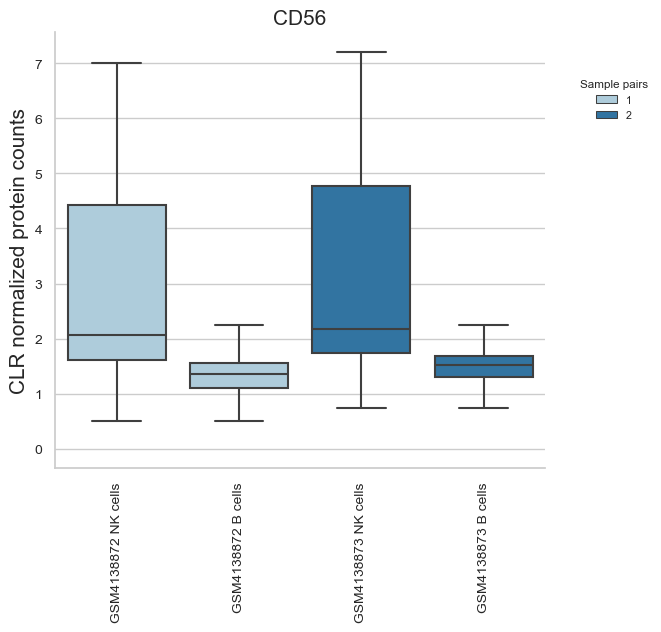

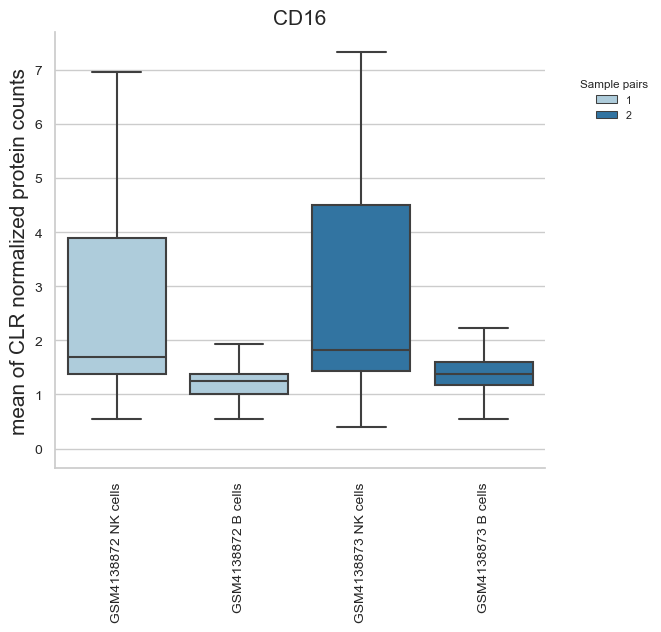

In [160]:
#CD56

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD56", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf_granja,
            legend = "CD56")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel=None)
ax.set_ylabels('CLR normalized protein counts', fontsize= 15)
plt.title("CD56", fontsize=15)
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')


plt.show()

#CD16

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD16", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf_granja,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel=None)
ax.set_ylabels('mean of CLR normalized protein counts', fontsize= 15)
plt.title("CD16", fontsize=15)
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')


plt.show()

- These plots compare signals of known NK cell markers between NK and B cells
- Clearly higher signals of selectd markers is detected from NK cells when comparing to B cells. 
- There is not cell type annotation available for other 3 samples. Samples that are missing cell type annotations represent MPAL (n=2) and CD34+ BM samples. 



- GSM4138880 = MPAL
- GSM4138880 = MPAL 
- GSM4138872 = healthy BMMC 
- GSM4138873 = healthy BMMC 
- GSM4138874 = CD34+ BM
 

### Easigenomics

In [81]:
samples_e=adata_easi.obs['POOL'].unique().tolist()

In [82]:
# only NK cells?

### Seurat

In [83]:
adata_seurat.obs["cell_type"].unique().tolist()

['Prog_RBC',
 'gdT',
 'CD4 Naive',
 'CD4 Memory',
 'CD14 Mono',
 'Naive B',
 'CD8 Naive',
 'Treg',
 'CD8 Effector_2',
 'NK',
 'GMP',
 'CD8 Effector_1',
 'CD16 Mono',
 'pDC',
 'CD8 Memory_1',
 'MAIT',
 'Memory B',
 'cDC2',
 'CD56 bright NK',
 'Prog_B 2',
 'Prog_Mk',
 'CD8 Memory_2',
 'Plasmablast',
 'HSC',
 'LMPP',
 'Prog_DC',
 'Prog_B 1']

In [84]:
samples_s=adata_seurat.obs['POOL'].unique().tolist()
samples_s

['Seurat']

In [85]:
listOfmarkers= nk_all

nk_seurat= []

for x in listOfmarkers:
    if x in seurat_nk_prot.columns:
        nk_seurat.append(x)

In [86]:
nk_seurat

['CD127', 'CD56', 'CD69', 'CD16', 'CD57', 'CD38', 'CD34', 'CD27', 'CD161']

In [87]:
#saving NK markers from all samples into a list

list_samples_s=[]

for sample in samples_s:
    eg=adata_seurat[adata_seurat.obs['cell_type'] == 'NK']
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_seurat']
    prot_marker=prot[nk_seurat]
    list_samples_s.append(prot_marker)

In [88]:
string= " NK cells"

samples_s = [x + string for x in samples_s]

In [89]:
list_seurat=[]

for i in range(len(list_samples_s)):
    sample= list_samples_s[i]
    sample["Sample"]=samples_s[i]
    list_seurat.append(sample)


In [90]:
df_all_s=pd.concat(list_seurat, axis=0)

In [91]:
df_all_s = df_all_s.T.drop_duplicates().T

In [92]:
samples_s=adata_seurat.obs['POOL'].unique().tolist()

In [93]:
samples_s

['Seurat']

In [94]:
#saving NK markers from all samples into a list, B cells

list_samples_s_b=[]

for sample in samples_s:
    eg=adata_seurat[adata_seurat.obs['cell_type'] == 'Naive B']
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_seurat']
    prot_marker=prot[nk_seurat]
    list_samples_s_b.append(prot_marker)

In [95]:
string= " B cells"

samples_s_b = [x + string for x in samples_s]

In [96]:
list_seurat_b=[]

for i in range(len(list_samples_s_b)):
    sample= list_samples_s_b[i]
    sample["Sample"]=samples_s_b[i]
    list_seurat_b.append(sample)

#creating df

df_all_s_b=pd.concat(list_seurat_b, axis=0)

In [97]:
#combining NK + B cell df

df=pd.concat([df_all_s, df_all_s_b], axis=0)

In [98]:
cdf_seurat = df[(df['Sample'] == "Seurat NK cells") | (df['Sample'] == 'Seurat B cells')].assign(Samplepair= 1)   


In [169]:
cdf_seurat.columns

Index(['CD127', 'CD56', 'CD69', 'CD16', 'CD57', 'CD38', 'CD34', 'CD27',
       'CD161', 'Sample', 'Samplepair'],
      dtype='object')

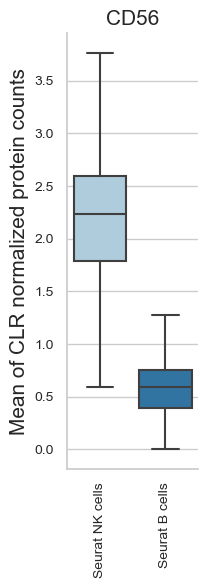

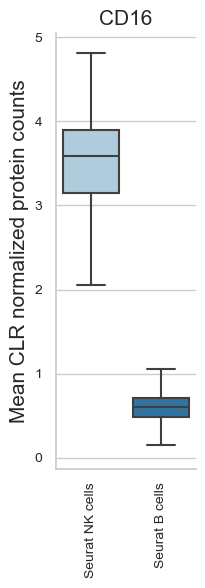

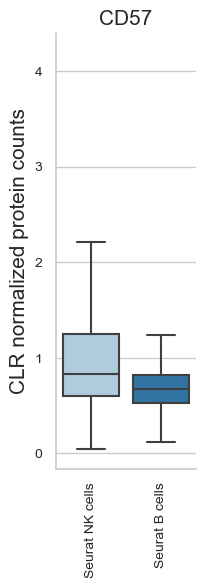

In [170]:
#CD56
sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD56",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf_seurat,
            legend = "CD56")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(2, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.title("CD56", fontsize=15)
ax.set(xlabel=None)
ax.set_ylabels('Mean of CLR normalized protein counts', fontsize= 15)
plt.show()

#CD16
sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD16",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf_seurat,
            legend = "CD56")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(2, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.title("CD16", fontsize=15)
ax.set(xlabel=None)
ax.set_ylabels('Mean CLR normalized protein counts', fontsize= 15)
plt.show()

#CD57
sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD57",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf_seurat,
            legend = "CD57")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(2, 5)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.title("CD57", fontsize=15)
ax.set(xlabel=None)
ax.set_ylabels('CLR normalized protein counts', fontsize= 15)
plt.show()


- These plots compare signals of known NK cell markers between NK and Naive B cells
- According to exprectations CD16 and CD56 signals are higher in NK cells than in B cells.
- Difference of signal of CD57 is not as clear between these two cell types. Similar observation has been done in other datasets as well. 